# Predictious Trading model using Time Series Econometrics
The following notebook will highlight a theoretical trading strategy based on techniques taken from the study of forecasting and the econometrics of time series.

In [1]:
#Data Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels
from matplotlib import rc
from statsmodels.tsa.arima_model import ARIMA as arima
from sklearn.metrics import mean_squared_error
import warnings
plt.style.use('dark_background')
rc('text', usetex=True)
warnings.filterwarnings("ignore")

### Fetching $TSLA price series (to the moon) - stonks

In [2]:
ticker = 'TSLA'
price_df = yf.download(ticker, start='2019-01-01',
                      end='2021-01-01')['Adj Close']
date = price_df.index.astype('O')
price_min = price_df.min()

[*********************100%***********************]  1 of 1 completed


(35.79399871826172, 705.6699829101562)

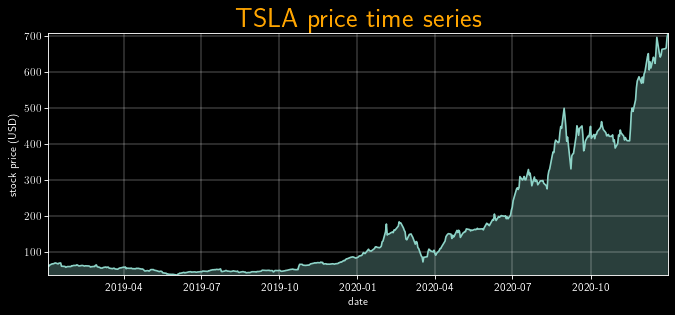

In [3]:
plt.figure(figsize=(10,4), dpi=80)
plt.plot(price_df)
plt.grid(linewidth=0.5)
plt.title('TSLA price time series', color='orange',
         fontsize=25)
plt.fill_between(date, price_min, price_df, alpha=0.3)
plt.xlabel('date')
plt.ylabel('stock price (USD)')
plt.grid(linewidth=0.3)
plt.xlim(date.min(), date.max())
plt.ylim(price_min, price_df.max())

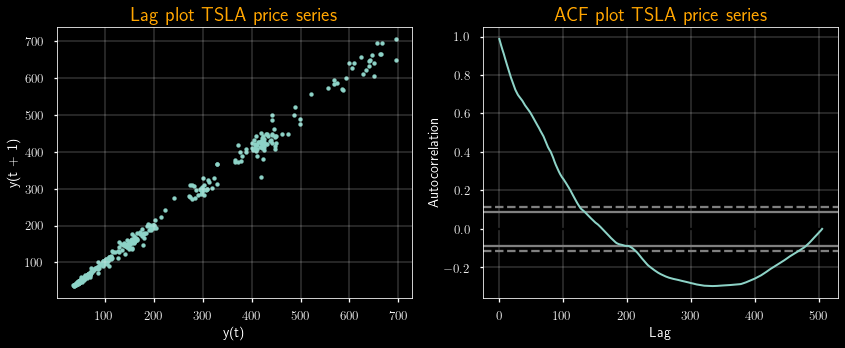

In [91]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
lag_plot(price_df, s=15, ax=ax[0])
ax[0].set_title('Lag plot TSLA price series',
               fontsize=20, color='orange')
ax[0].grid(linewidth=0.3)
autocorrelation_plot(price_df, ax=ax[1],
                    linewidth=2)
ax[1].set_title('ACF plot TSLA price series',
               fontsize=20, color='orange')
ax[1].grid(linewidth=0.3)

Although there appears to be a high level of autocorrelation between the time series data-points, this is because we are examining price time series instead of return time series, which could give falsely positive results.

(-0.5, 0.5)

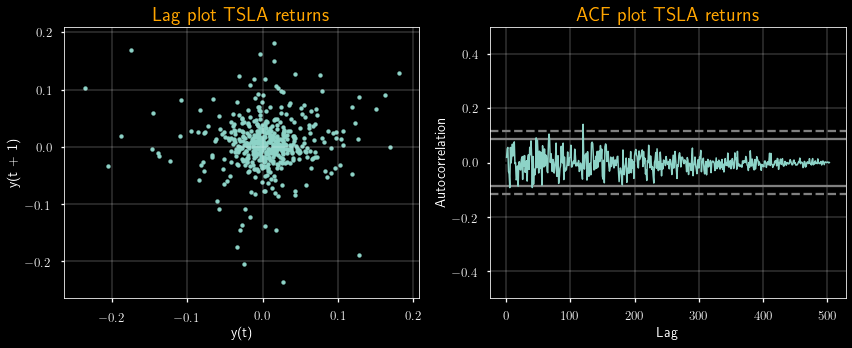

In [92]:
#Calculating log-returns
r = np.log(price_df) - np.log(price_df.shift(1)).dropna()
fig, ax = plt.subplots(1,2, figsize=(14,5))
lag_plot(r, s=15, ax=ax[0])
ax[0].set_title('Lag plot TSLA returns',
               fontsize=20, color='orange')
ax[0].grid(linewidth=0.3)
autocorrelation_plot(r[1:-1], ax=ax[1],
                    linewidth=1.5)
ax[1].set_title('ACF plot TSLA returns',
               fontsize=20, color='orange')
ax[1].grid(linewidth=0.3)
ax[1].set_ylim(-0.5, 0.5)

Although we do not observe a high amount of autocorrelation between time steps in the price series, we are still going to test a trading strategy based on short-term predictions.

In [258]:
#Splitting dataset so we have 400 observations in the training and 100 in the test set
price_array = np.array(price_df)
X = price_array
train, test = X[1:len(X)-50], X[len(X)-50:]
model_1 = arima(endog=train, order=(2,1,1)).fit()
print(model_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  453
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1679.909
Method:                       css-mle   S.D. of innovations              9.870
Date:                Fri, 19 Feb 2021   AIC                           3369.818
Time:                        10:50:25   BIC                           3390.397
Sample:                             1   HQIC                          3377.927
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7960      0.484      1.644      0.100      -0.153       1.745
ar.L1.D.y      0.2433      0.247      0.983      0.326      -0.242       0.728
ar.L2.D.y      0.0739      0.047      1.561      0.1

We determing the statistical significance of each of our terms when the p-value of the feature $\le$ $\alpha$, where in our case $\alpha = 0.05$ at a $95\%$ confidence level, we see all four of our features are statistically significant.\
Log-likelihood is very low, suggesting the model is not performing optimally, combined with the high AIC and BIC (the lower these measures the better the model is performing)

The test MSE is: 295107.033


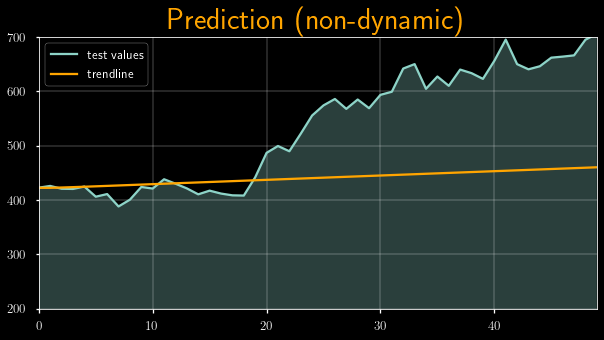

In [259]:
#Making predictions

predictions = model_1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
error = mean_squared_error(test, predictions)
print('The test MSE is: %.3f' % error)
pred = np.cumsum(predictions)

plt.figure(figsize=(10,5))
xvals = np.arange(0,len(test))
plt.plot(xvals, test, label='test values')
plt.plot(pred + X[len(train)], color='orange',
        label='trendline')
plt.fill_between(xvals, 0, test, alpha=0.3)
plt.grid(linewidth=0.3)
plt.ylim(200, 700)
plt.xlim(0,len(test)-1)
plt.title('Prediction (non-dynamic)', color='orange',
         fontsize=30)
plt.legend()

However, the accuracy of this is quite poor, which is why it is more useful to make dynamic predictions

# Dynamic Predictious model

In [280]:
xindex = np.arange(0,len(X))
dynamic = pd.Series(np.zeros(len(X),) * np.nan, index=xindex)
for t in range(len(X)-len(test),len(X)-3):
    model = arima(X[:t], order = (2,1,1))
    model_fit = model.fit()
    model_forecast = model_fit.forecast()[0]
    dynamic.loc[t] = model_forecast

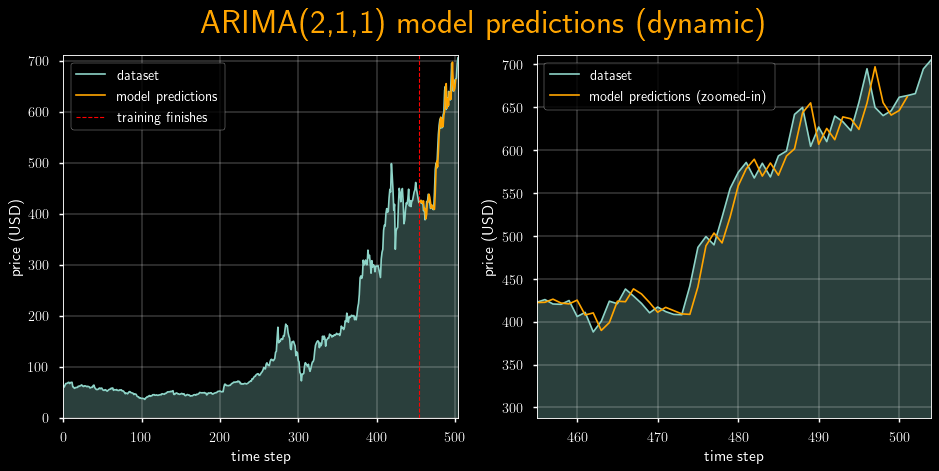

In [282]:
fig, ax = plt.subplots(1,2, figsize=(14,6),
                      dpi=80)
fig.suptitle('ARIMA(2,1,1) model predictions (dynamic)',
            color='orange', fontsize=30)
ax[0].plot(X, linewidth=1.5, label='dataset')
ax[0].plot(dynamic, color='orange',
          linewidth=1.5, label='model predictions')
ax[0].grid(linewidth=0.3)
ax[0].fill_between(xindex, 0, X, alpha=0.3)
ax[0].set_xlim(min(xindex),max(xindex))
ax[0].set_ylim(0, max(X)+5)
ax[0].axvline(len(train), color='red', linestyle='--', 
              linewidth=1, label='training finishes')
ax[0].set_xlabel('time step')
ax[0].set_ylabel('price (USD)')
ax[0].legend()

testindex = np.arange(len(train)+1, len(X))
ax[1].plot(testindex, test, linewidth=1.5, label='dataset')
ax[1].plot(dynamic, color='orange',
          linewidth=1.5, label='model predictions (zoomed-in)')
ax[1].grid(linewidth=0.3)
ax[1].fill_between(testindex, 0, test, alpha=0.3)
ax[1].set_xlim(min(testindex),max(testindex))
ax[1].set_ylim(min(test)-100, max(test)+5)
ax[1].set_xlabel('time step')
ax[1].set_ylabel('price (USD)')
ax[1].legend()

### Looking for locally stationary data in TSLA price series